In [1]:
import pprint
import subprocess
import sys 
sys.path.append('../')

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

%matplotlib inline
plt.rcParams['figure.figsize'] = (12.9, 12)

np.set_printoptions(suppress=True, precision=5)

sns.set(font_scale=3.5)

from network import Protocol, NetworkManager, BCPNNPerfect
from plotting_functions import plot_weight_matrix, plot_state_variables_vs_time, plot_winning_pattern
from plotting_functions import plot_network_activity, plot_network_activity_angle
from analysis_functions import calculate_recall_time_quantities, calculate_angle_from_history, get_weights
from connectivity_functions import artificial_connectivity_matrix

## Creating input

In [2]:
training_time = 0.100
n_patterns = 10
dt = 0.001
minicolumns = 10
hypercolumns = 2
n_units = minicolumns * hypercolumns

n_time_total = int((training_time / dt) * n_patterns)
T_total = training_time * n_patterns
time = np.linspace(0, T_total, num=n_time_total)

In [3]:
def create_orthogonal_canonical_representation(minicolumns, hypercolumns):
    aux = []
    for i in range(minicolumns):
        aux.append(i * np.ones(hypercolumns))

    return np.array(aux, dtype='int')

In [4]:
matrix = create_orthogonal_canonical_representation(minicolumns, hypercolumns)
matrix

array([[0, 0],
       [1, 1],
       [2, 2],
       [3, 3],
       [4, 4],
       [5, 5],
       [6, 6],
       [7, 7],
       [8, 8],
       [9, 9]])

In [5]:
def build_network_representation(matrix, minicolumns, hypercolumns):

    network_representation = np.zeros((len(matrix), minicolumns * hypercolumns), dtype='int')

    for patten, indexes in enumerate(matrix):
        for hypercolumn_index, minicolumn_index in enumerate(indexes):
            index = hypercolumn_index * minicolumns + minicolumn_index
            network_representation[patten, index] = 1
    
    return network_representation
    
network_representation = build_network_representation(matrix, minicolumns, hypercolumns)

In [6]:
# This input should be filled
S = np.zeros((minicolumns * hypercolumns, n_time_total))
pattern_length = int(training_time / dt)

end = 0
for pattern in range(n_patterns):
    start = end
    end = start + pattern_length  
    indexes = np.where(network_representation[pattern])[0]
    S[indexes, start:end] = 1

Let's visualizate the input

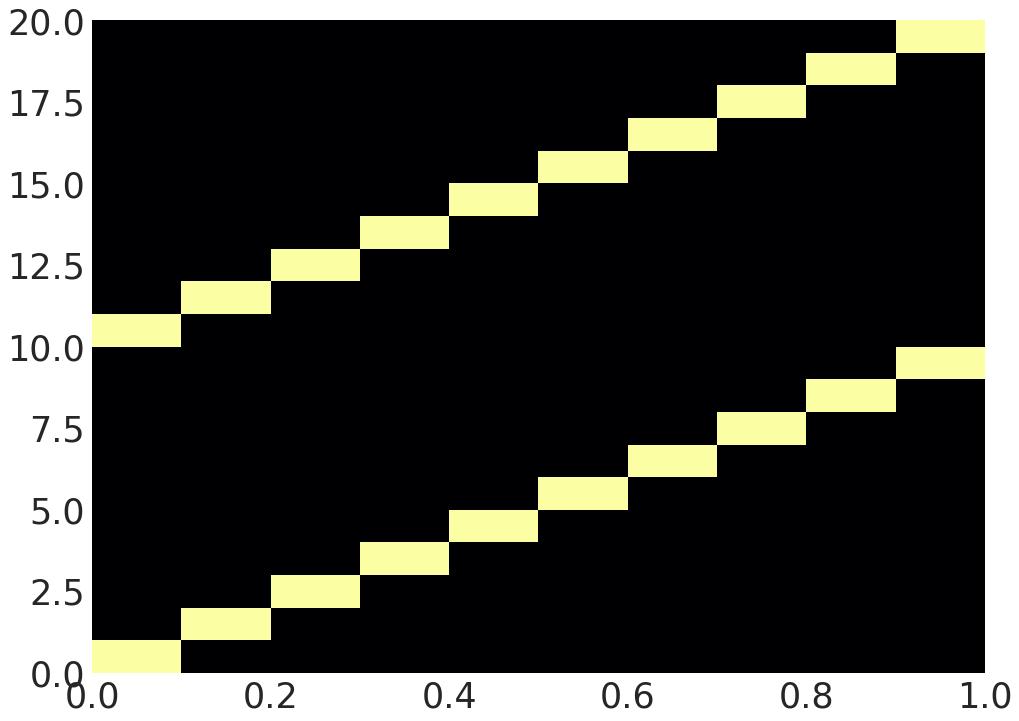

In [7]:
figsize = (16, 12)
cmap = matplotlib.cm.inferno

extent = [0, T_total, 0, minicolumns * hypercolumns]

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
im = ax.imshow(S, cmap=cmap, origin='lower', extent=extent, aspect='auto')
ax.grid(0)

Let's build the weights from the canonical representation (w and biases) with the BCPNN learning rule, then let's build them using the time version of it

In [8]:
pi = network_representation.sum(axis=0) 
pij = np.zeros((n_units, n_units))
for pattern in network_representation:
    pij += pattern[:, np.newaxis] @ pattern[np.newaxis, :]
    
pi = pi / n_patterns
pij /= n_patterns

In [10]:
aux = np.copy(pi)
aux[pi == 0] = 1.0 / n_patterns ** 2
beta = np.log(aux)

w = np.zeros((n_units, n_units))

for index1, p1 in enumerate(pi):
    for index2, p2 in enumerate(pi):
        if p1==0 or p2==0:
            w[index1, index2] = 1.0
        elif pij[index1, index2] == 0:
            w[index1, index2] = 1 / n_patterns
        else:
            w[index1, index2] = pij[index1, index2] / (p1 * p2)
            
w = np.log(w)

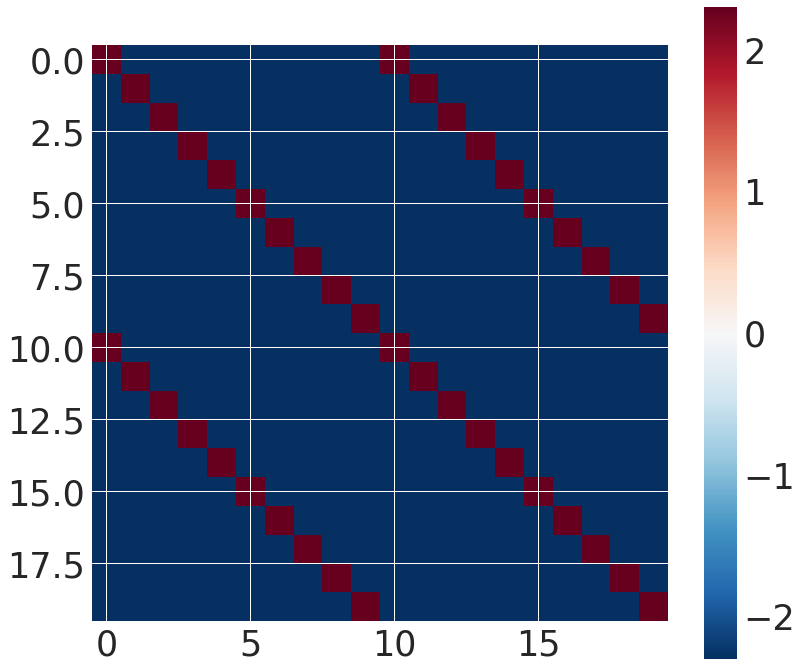

In [11]:
cmap = matplotlib.cm.RdBu_r
plt.imshow(w, cmap=cmap)
plt.colorbar();

In [12]:
import scipy as sp

In [13]:
p = sp.integrate.simps(y=S, x=time, axis=1) / T_total

outer_product = np.zeros((n_units, n_units, n_time_total))
for index, s in enumerate(S.T):
    outer_product[:, :, index] = s[:, np.newaxis] @ s[np.newaxis, :]
    
P = sp.integrate.simps(y=outer_product, x=time, axis=2) / T_total

In [14]:
w_time = np.zeros((n_units, n_units))

for index1, p1 in enumerate(p):
    for index2, p2 in enumerate(p):
        if p1==0 or p2==0:
            w_time[index1, index2] = 1.0
        elif P[index1, index2] == 0:
            w_time[index1, index2] = 1 / n_patterns
        else:
            w_time[index1, index2] = P[index1, index2] / (p1 * p2)
            
w_time = np.log(w_time)

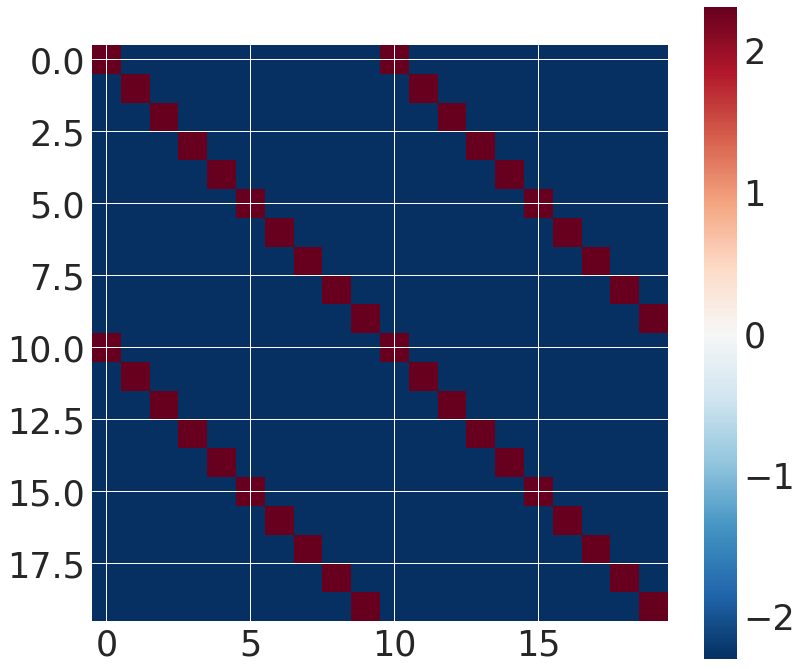

In [15]:
cmap = matplotlib.cm.RdBu_r
plt.imshow(w_time, cmap=cmap)
plt.colorbar();

I want to filter the input now.

In [16]:
S.shape

(20, 1000)

In [17]:
tau_z = 0.050
z = np.zeros_like(S)
for index, s in enumerate(S.T):
    if index == 0:
        z[:, index] = (dt / tau_z) * (s - 0)
    else:
        z[:, index] = z[:, index - 1] + (dt / tau_z) * (s - z[:, index - 1])

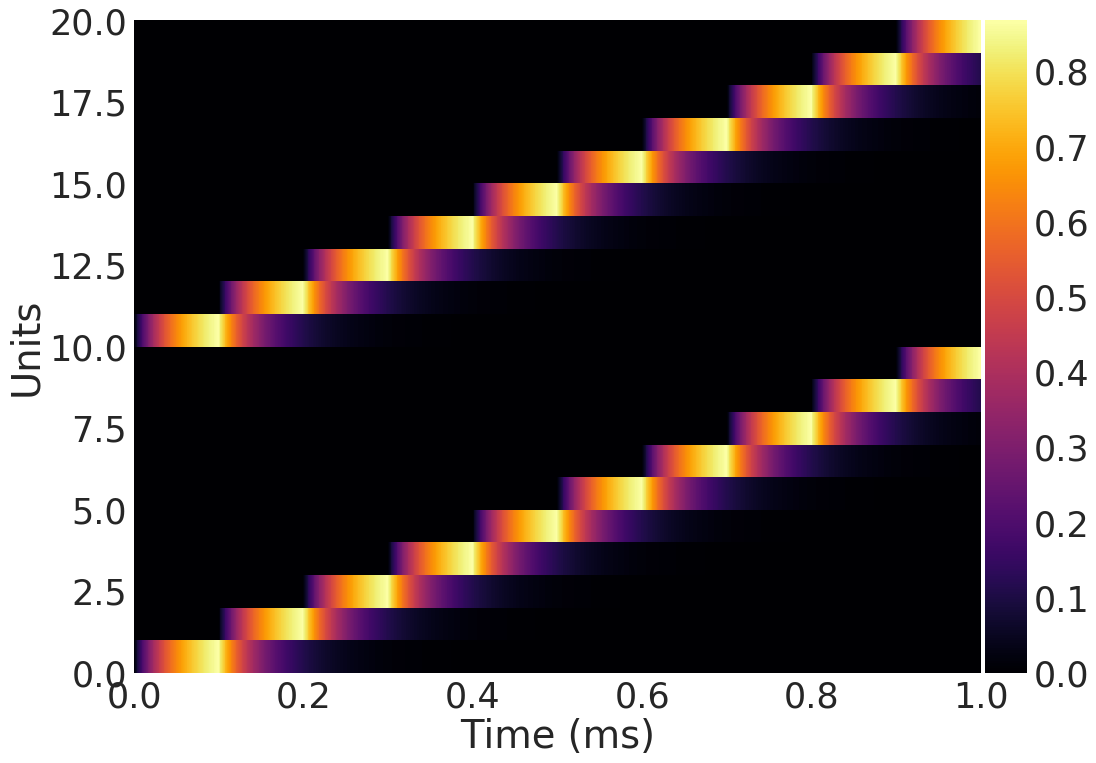

In [18]:
figsize = (16, 12)
cmap = matplotlib.cm.inferno

extent = [0, T_total, 0, minicolumns * hypercolumns]

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
im = ax.imshow(z, cmap=cmap, origin='lower', extent=extent, aspect='auto')
ax.grid(0)

ax.set_xlabel('Time (ms)')
ax.set_ylabel('Units')

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical');

In [19]:
p = sp.integrate.simps(y=z, x=time, axis=1) / T_total

outer_product = np.zeros((n_units, n_units, n_time_total))
for index, s in enumerate(z.T):
    outer_product[:, :, index] = s[:, np.newaxis] @ s[np.newaxis, :]
    
P = sp.integrate.simps(y=outer_product, x=time, axis=2) / T_total
p[p < (1 / n_patterns)] 

array([ 0.1    ,  0.09934,  0.0944 ,  0.05712,  0.1    ,  0.09934,
        0.0944 ,  0.05712])

In [20]:
training_time / T_total

0.1

In [21]:
to_index = 0
from_index = 1
print(P[to_index, from_index])
print(p[from_index] * p[to_index])
print(P[to_index, from_index] / (p[from_index] * p[to_index]))

0.0186373711621
0.0100191912313
1.86016722625


In [22]:
w_time = np.zeros((n_units, n_units))

for index1, p1 in enumerate(p):
    for index2, p2 in enumerate(p):
        if p1==0 or p2==0:
            w_time[index1, index2] = 1.0
        elif P[index1, index2] < 0.001:
            w_time[index1, index2] = 0.001
        else:
            w_time[index1, index2] = P[index1, index2] / (p1 * p2)
            
w_time = np.log(w_time)

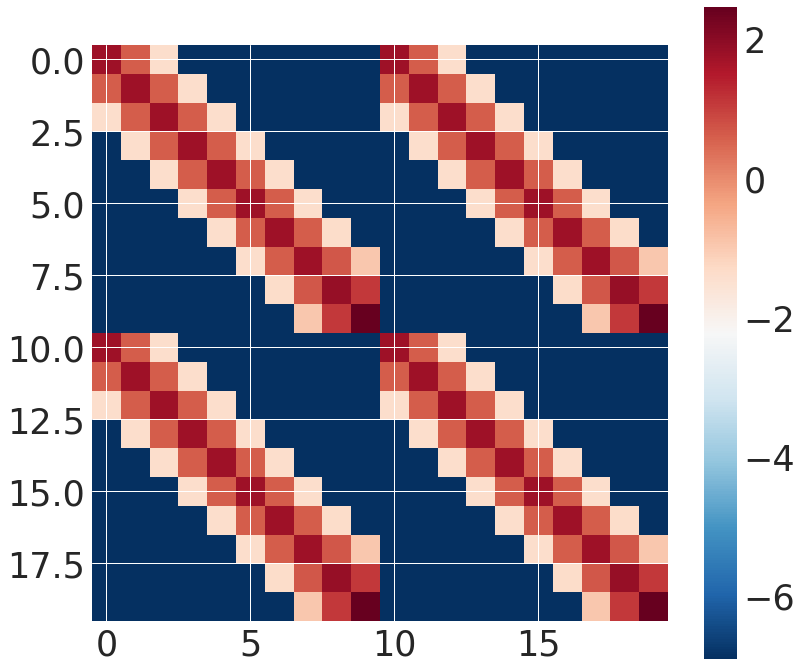

In [23]:
cmap = matplotlib.cm.RdBu_r
plt.imshow(w_time, cmap=cmap)
plt.colorbar();

## Let's make everything a function

In [24]:
training_time = 0.100
n_patterns = 10
dt = 0.001
minicolumns = 10
hypercolumns = 2
n_units = minicolumns * hypercolumns

T_total = training_time * n_patterns
time = np.linspace(0, T_total, num=n_time_total)

matrix = create_orthogonal_canonical_representation(minicolumns, hypercolumns)
network_representation = build_network_representation(matrix, minicolumns, hypercolumns)

In [113]:
network_representation.shape

(10, 20)

In [192]:
class TimedInput:
    def __init__(self, minicolumns, hypercolumns, network_representation, dt, training_time, inter_pulse_interval=0.0,
                     inter_sequence_interval=0.0, epochs=1):
        
        self.n_units = network_representation.shape[1]
        self.dt = dt
        
        self.network_representation = network_representation
        self.epochs = epochs
        self.training_time = training_time
        self.inter_pulse_interval = inter_pulse_interval
        self.inter_sequence_interval = inter_sequence_interval
        
        self.n_patterns = network_representation.shape[0]
        self.pattern_length = int(training_time / dt)
        self.inter_pulse_interval_length = int(inter_pulse_interval / dt)
        self.inter_sequence_interval_length = int(inter_sequence_interval / dt)

        self.n_time_total = (self.pattern_length + self.inter_pulse_interval_length) * self.n_patterns
        self.n_time_total += self.inter_sequence_interval_length
        self.n_time_total *= epochs
        self.T_total = epochs * ((training_time + inter_pulse_interval) * n_patterns + inter_sequence_interval)
        self.time = np.linspace(0, self.T_total, num=self.n_time_total)

        
        self.S = np.zeros((self.n_units, self.n_time_total))
        self.z = z = np.zeros_like(self.S)


    def build_timed_input(self):      
        end = 0
        for epoch in range(self.epochs):
            for pattern in range(self.n_patterns):
                start = end
                end = start + self.pattern_length  
                indexes = np.where(self.network_representation[pattern])[0]
                self.S[indexes, start:end] = 1
                end += self.inter_pulse_interval_length
            end += self.inter_sequence_interval_length
    
        return self.S
    
    def build_filtered_input(self, tau_z):
        for index, s in enumerate(self.S.T):
            if index == 0:
                self.z[:, index] = (self.dt / tau_z) * (s - 0)
            else:
                self.z[:, index] = self.z[:, index - 1] + (self.dt / tau_z) * (s - self.z[:, index - 1])
        
        return self.z

In [140]:
timed_input = TimedInput(minicolumns, hypercolumns, network_representation, dt, training_time, inter_pulse_interval=0.0,
                         inter_sequence_interval=0, epochs=1)
S = timed_input.build_timed_input()

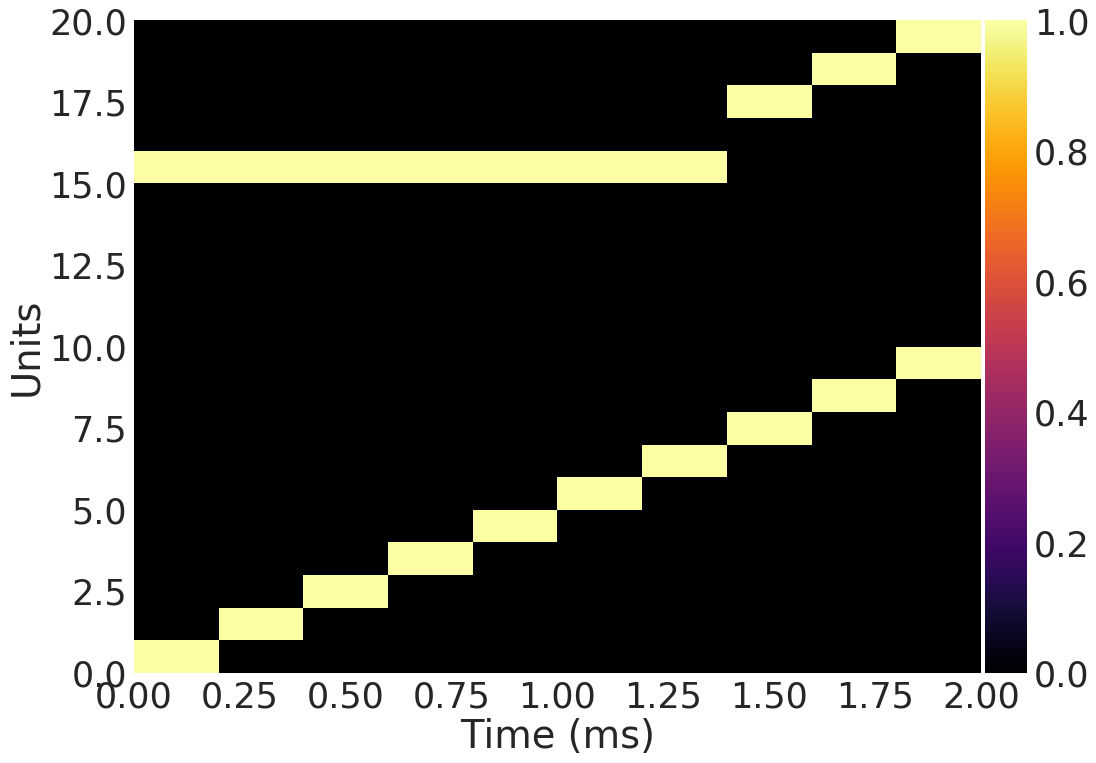

In [141]:
figsize = (16, 12)
cmap = matplotlib.cm.inferno

extent = [0, T_total, 0, minicolumns * hypercolumns]

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
im = ax.imshow(S, cmap=cmap, origin='lower', extent=extent, aspect='auto')
ax.grid(0)

ax.set_xlabel('Time (ms)')
ax.set_ylabel('Units')

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical');

In [142]:
matrix = create_orthogonal_canonical_representation(minicolumns, hypercolumns)

for i in range(n_patterns - 3):
    matrix[i][1] = 5

In [143]:
network_representation = build_network_representation(matrix, minicolumns, hypercolumns)

In [144]:
timed_input = TimedInput(minicolumns, hypercolumns, network_representation, dt, training_time, inter_pulse_interval=0.100,
                         inter_sequence_interval=0, epochs=1)
S = timed_input.build_timed_input()

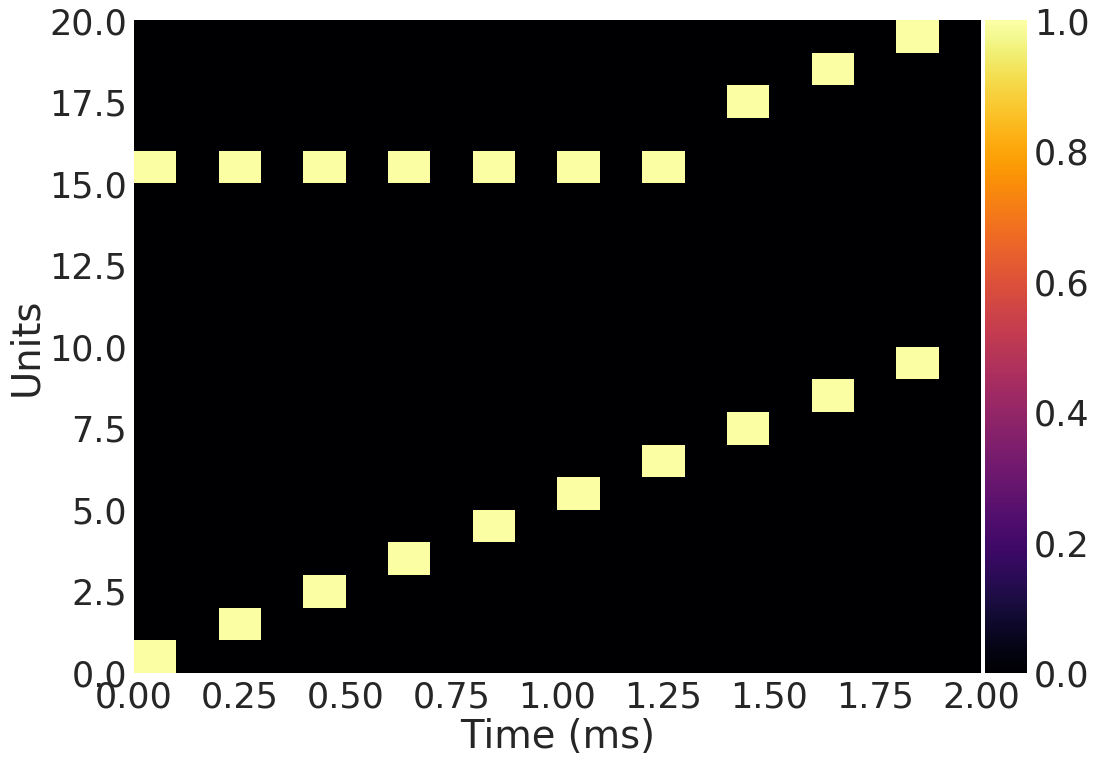

In [145]:
igsize = (16, 12)
cmap = matplotlib.cm.inferno

extent = [0, T_total, 0, minicolumns * hypercolumns]

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
im = ax.imshow(S, cmap=cmap, origin='lower', extent=extent, aspect='auto')
ax.grid(0)

ax.set_xlabel('Time (ms)')
ax.set_ylabel('Units')

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical');

In [260]:
def get_probabilities_from_network_representation(network_representation):
    
    n_patterns = network_representation.shape[0]
    n_units = network_representation.shape[1]
    
    pi = network_representation.sum(axis=0) 
    
    pij = np.zeros((n_units, n_units))
    for pattern in network_representation:
        pij += pattern[:, np.newaxis] @ pattern[np.newaxis, :]

    pi = pi / n_patterns
    pij /= n_patterns
    
    return pi, pij

def get_weights_from_probabilities(pi, pj, pij, minicolumns, hypercolumns, small_number=10e-3):
    if pj is None:
        pj = pi
    
    n_units = minicolumns * hypercolumns
    
    aux = np.copy(pi)
    aux[pi < small_number] = small_number
    beta = np.log(aux)

    w = np.zeros((n_units, n_units))

    for index1, p1 in enumerate(pi):
        for index2, p2 in enumerate(pi):
            if p1==0 or p2==0:
                w[index1, index2] = 1.0
            elif pij[index1, index2] < small_number:
                w[index1, index2] = small_number
            else:
                w[index1, index2] = pij[index1, index2] / (p1 * p2)

    w = np.log(w)
    
    return w

In [261]:
pi, pij = get_probabilities_from_network_representation(network_representation)
w = get_weights_from_probabilities(pi, pi, pij, minicolumns, hypercolumns)

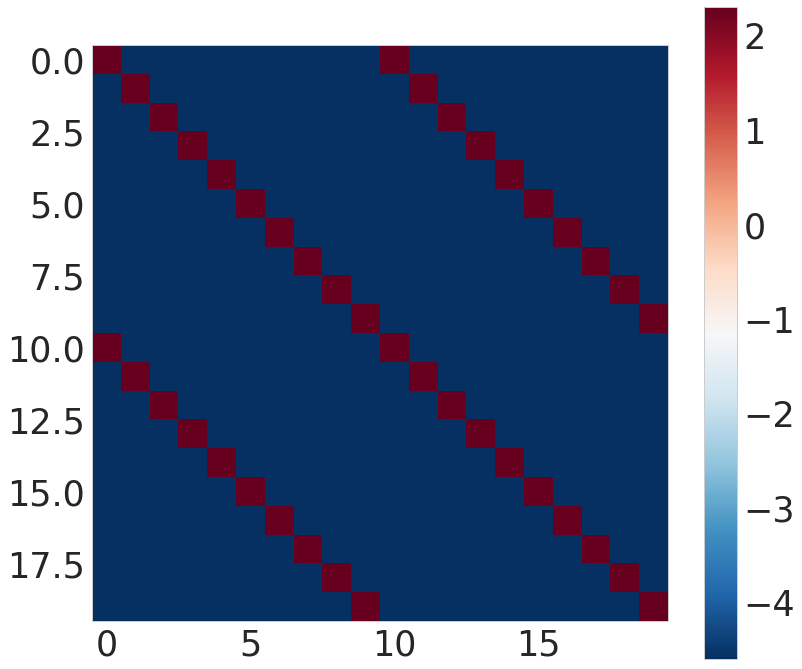

In [262]:
cmap = matplotlib.cm.RdBu_r
plt.imshow(w, cmap=cmap)
plt.colorbar();

In [266]:
def calculate_probabilities_from_time_signal(timed_input, filtered=False):
    if filtered:
        y = timed_input.z
    else:
        y = timed_input.S
    
    n_units = timed_input.n_units
    n_time_total = timed_input.n_time_total
    
    p = sp.integrate.simps(y=y, x=timed_input.time, axis=1) / timed_input.T_total

    outer_product = np.zeros((n_units, n_units, n_time_total))
    for index, s in enumerate(y.T):
        outer_product[:, :, index] = s[:, np.newaxis] @ s[np.newaxis, :]

    P = sp.integrate.simps(y=outer_product, x=timed_input.time, axis=2) / timed_input.T_total
    
    return p, P

In [267]:
p, P = calculate_probabilities_from_time_signal(timed_input)
w = get_weights_from_probabilities(p, p, P, minicolumns, hypercolumns)

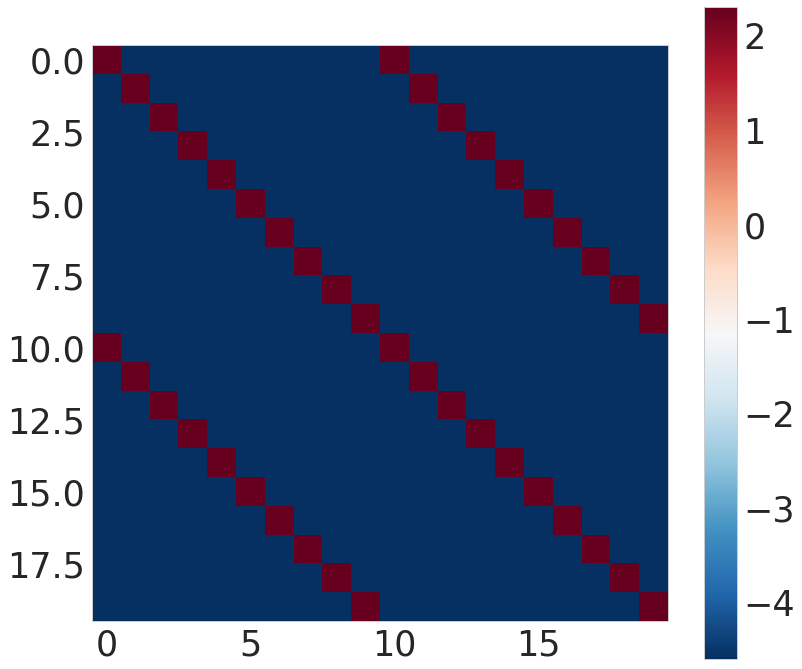

In [268]:
cmap = matplotlib.cm.RdBu_r
plt.imshow(w, cmap=cmap)
plt.colorbar();

Compare everything in one cell

0.000447437314157
0.000632771917993


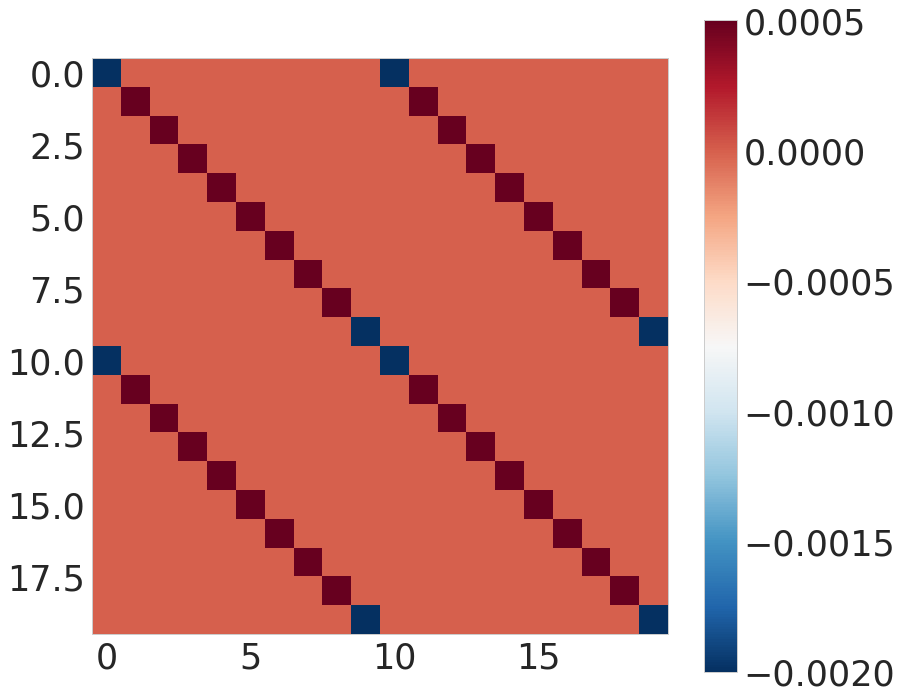

In [269]:
training_time = 0.100
n_patterns = 10
dt = 0.001
minicolumns = 10
hypercolumns = 2
n_units = minicolumns * hypercolumns

time = np.linspace(0, T_total, num=n_time_total)

matrix = create_orthogonal_canonical_representation(minicolumns, hypercolumns)
network_representation = build_network_representation(matrix, minicolumns, hypercolumns)

timed_input = TimedInput(minicolumns, hypercolumns, network_representation, dt, training_time, inter_pulse_interval=0.0,
                         inter_sequence_interval=0.0, epochs=2)
S = timed_input.build_timed_input()

pi, pij = get_probabilities_from_network_representation(network_representation)
w_static = get_weights_from_probabilities(pi, pi, pij, minicolumns, hypercolumns)

p, P = calculate_probabilities_from_time_signal(timed_input)
w_timed = get_weights_from_probabilities(p, p, P, minicolumns, hypercolumns)

print(np.linalg.norm(p - pi))
print(np.linalg.norm(P - pij))

cmap = matplotlib.cm.RdBu_r
plt.imshow(w_static - w_timed, cmap=cmap)
plt.colorbar();

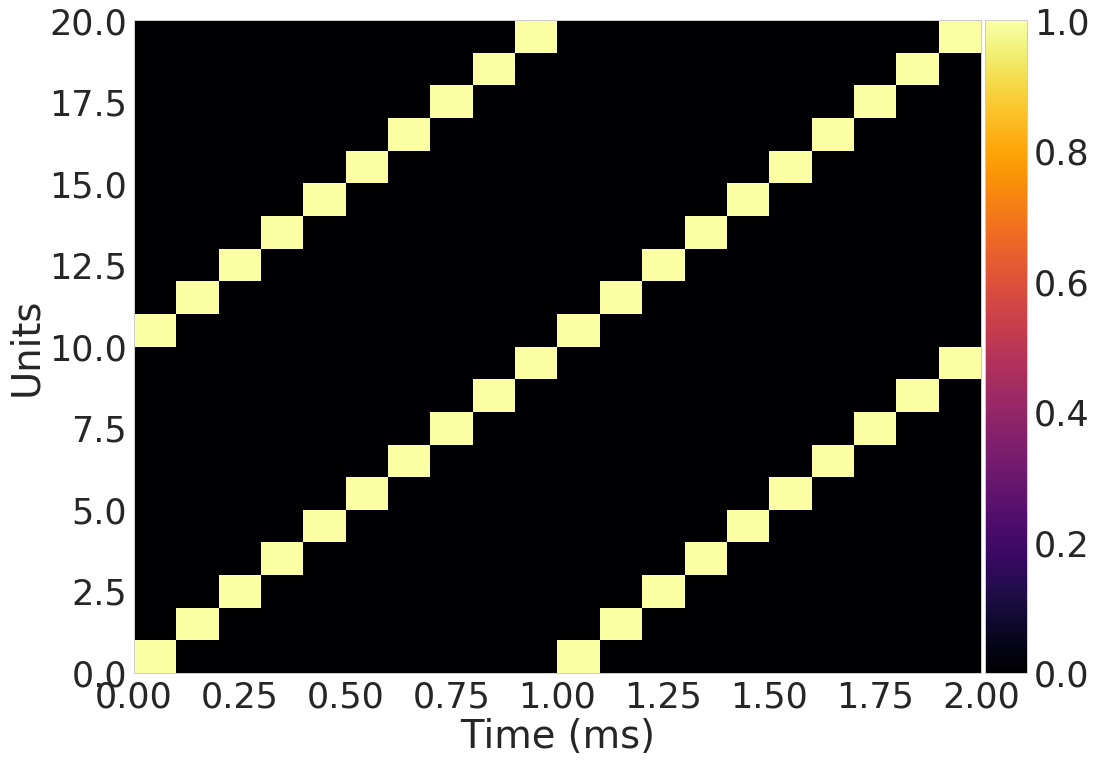

In [270]:
figsize = (16, 12)
cmap = matplotlib.cm.inferno

extent = [0, timed_input.T_total, 0, minicolumns * hypercolumns]

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
im = ax.imshow(S, cmap=cmap, origin='lower', extent=extent, aspect='auto')
ax.grid(0)

ax.set_xlabel('Time (ms)')
ax.set_ylabel('Units')

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical');

Now for the filtered input

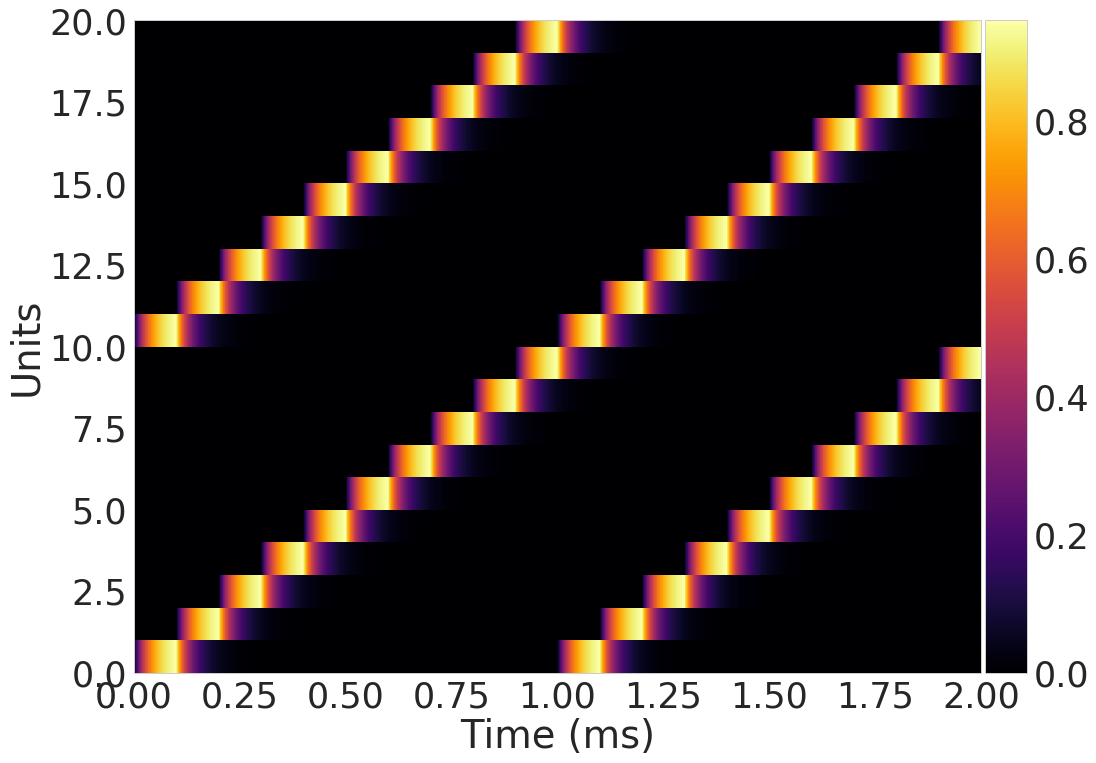

In [271]:
tau_z = 0.035
z = timed_input.build_filtered_input(tau_z)

figsize = (16, 12)
cmap = matplotlib.cm.inferno

extent = [0, timed_input.T_total, 0, minicolumns * hypercolumns]

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
im = ax.imshow(z, cmap=cmap, origin='lower', extent=extent, aspect='auto')
ax.grid(0)

ax.set_xlabel('Time (ms)')
ax.set_ylabel('Units')

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical');

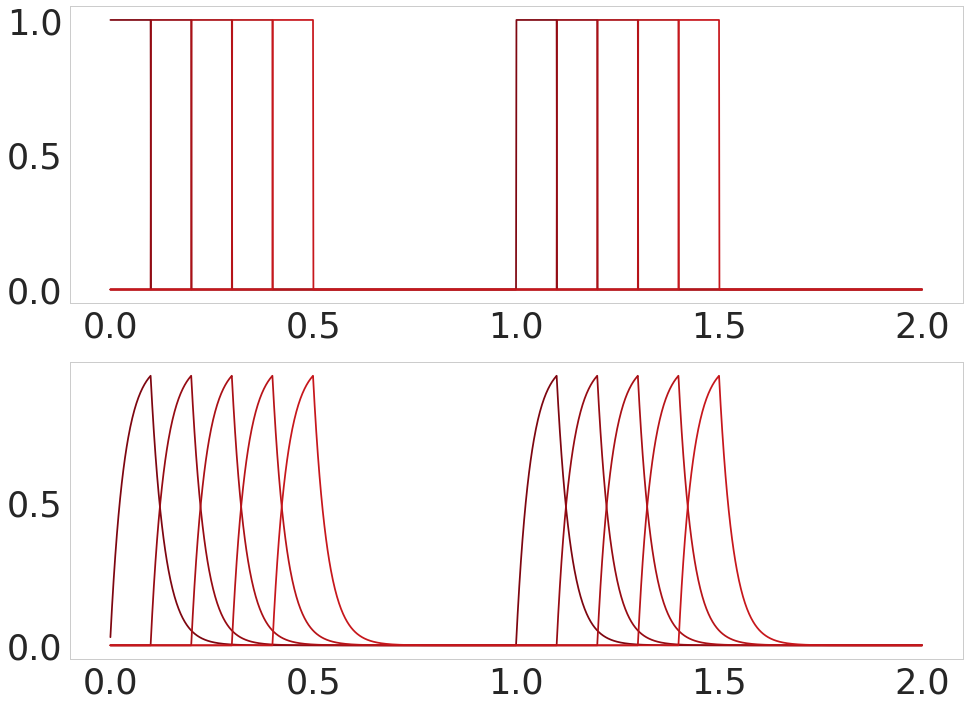

In [272]:
palette = sns.color_palette("Reds_r", S.shape[0])
fig = plt.figure(figsize=figsize)
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)



for index, s in enumerate(S):
    if index < 5:
        ax1.plot(timed_input.time, s, color=palette[index])
        ax2.plot(timed_input.time, z[index, :], color=palette[index] )

Pij 0.00222333388826
pi * pj 0.0100046529377
ratio 0.222229986597
log -1.5040424577


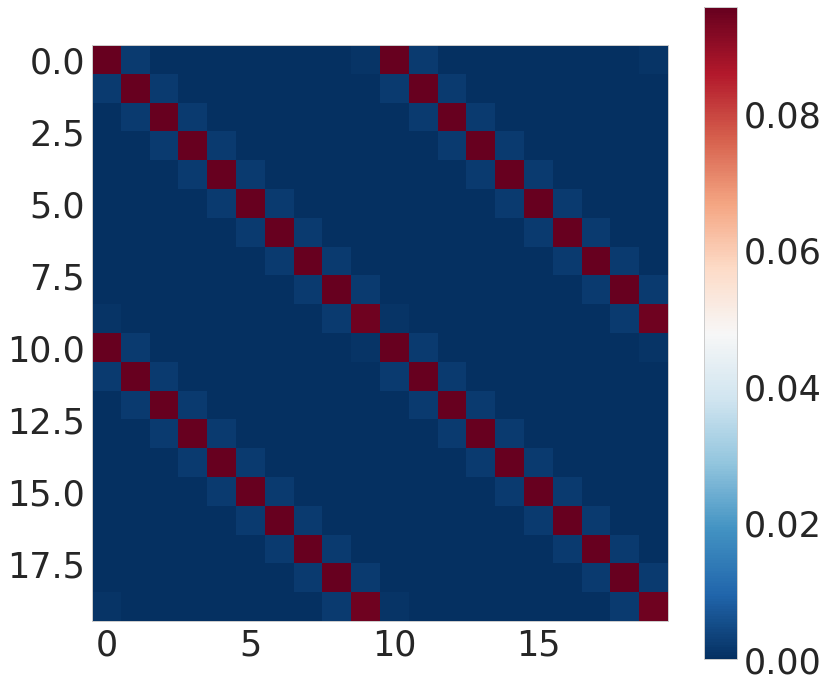

In [277]:
tau_z_pre = 0.100
z_pre = timed_input.build_filtered_input(tau_z_pre)
pi, P = calculate_probabilities_from_time_signal(timed_input, filtered=True)
tau_z_post = 0.005
z_post = timed_input.build_filtered_input(tau_z_post)
pj, P = calculate_probabilities_from_time_signal(timed_input, filtered=True)
w_timed = get_weights_from_probabilities(pi, pj, P, minicolumns, hypercolumns)

to_index = 0
from_index = 1
print('Pij', P[to_index, from_index])
print('pi * pj', pi[from_index] * pj[to_index])
print('ratio', P[to_index, from_index] / (pi[from_index] * pj[to_index]))
print('log', np.log(P[to_index, from_index] / (pi[from_index] * pj[to_index])))

cmap = matplotlib.cm.RdBu_r
plt.imshow(w, cmap=cmap)
plt.colorbar();

## Let's put this into a matrix

/home/heberto/miniconda/envs/python3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/heberto/miniconda/envs/python3/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/heberto/miniconda/envs/python3/lib/python3.5/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/heberto/miniconda/envs/python3/lib/python3.5/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/heberto/miniconda/envs/python3/lib/python3.5/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


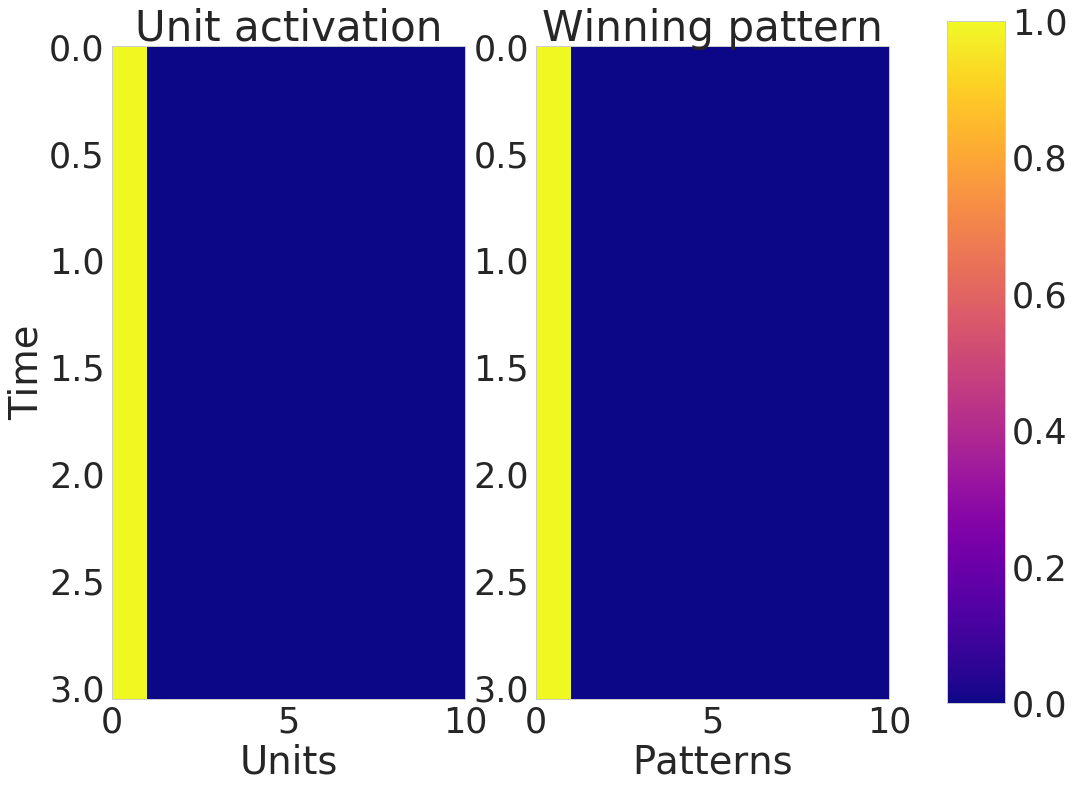

In [221]:
always_learning = False
strict_maximum = True
perfect = False
z_transfer = False
k_perfect = True
diagonal_zero = False

g_w_ampa = 2.0
g_w = 0.0
g_a = 10.0
tau_a = 0.250
G = 1.0
sigma = 0.0
tau_m = 0.020
tau_z_pre_ampa = 0.025
tau_z_post_ampa = 0.005
tau_p = 10.0

matrix = create_orthogonal_canonical_representation(minicolumns, hypercolumns)
network_representation = build_network_representation(matrix, minicolumns, hypercolumns)

timed_input = TimedInput(minicolumns, hypercolumns, network_representation, dt, training_time, inter_pulse_interval=0.0,
                         inter_sequence_interval=0.0, epochs=2)
S = timed_input.build_timed_input()
z = timed_input.build_filtered_input(0.030)

p, P = calculate_probabilities_from_time_signal(timed_input, filtered=True)
w_timed = get_weights_from_probabilities(p, P, minicolumns, hypercolumns)


# Patterns parameters
hypercolumns = 1
minicolumns = 10
n_patterns = 10

# Manager properties
dt = 0.001
values_to_save = ['o']

# Protocol
training_time = 0.200
inter_sequence_interval = 1.0
inter_pulse_interval = 0.0
epochs = 3

# Recall
T_recall = 3.0
n = 1
T_cue = 0.050

nn = BCPNNPerfect(hypercolumns, minicolumns, g_w_ampa=g_w_ampa, g_w=g_w, g_a=g_a, tau_a=tau_a, tau_m=tau_m,
                  sigma=sigma, G=G, tau_z_pre_ampa=tau_z_pre_ampa, tau_z_post_ampa=tau_z_post_ampa, tau_p=tau_p,
                  z_transfer=z_transfer, diagonal_zero=diagonal_zero, strict_maximum=strict_maximum, 
                  perfect=perfect, k_perfect=k_perfect, always_learning=always_learning)

# Build the manager
manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)

# Build the protocol for training
nn.w_ampa = w_timed

# Recall
patterns_indexes = [i for i in range(n_patterns)]
sequences = [patterns_indexes]
aux = calculate_recall_time_quantities(manager, T_recall, T_cue, n, sequences)
total_sequence_time, mean, std, success, timings = aux

plot_network_activity_angle(manager)

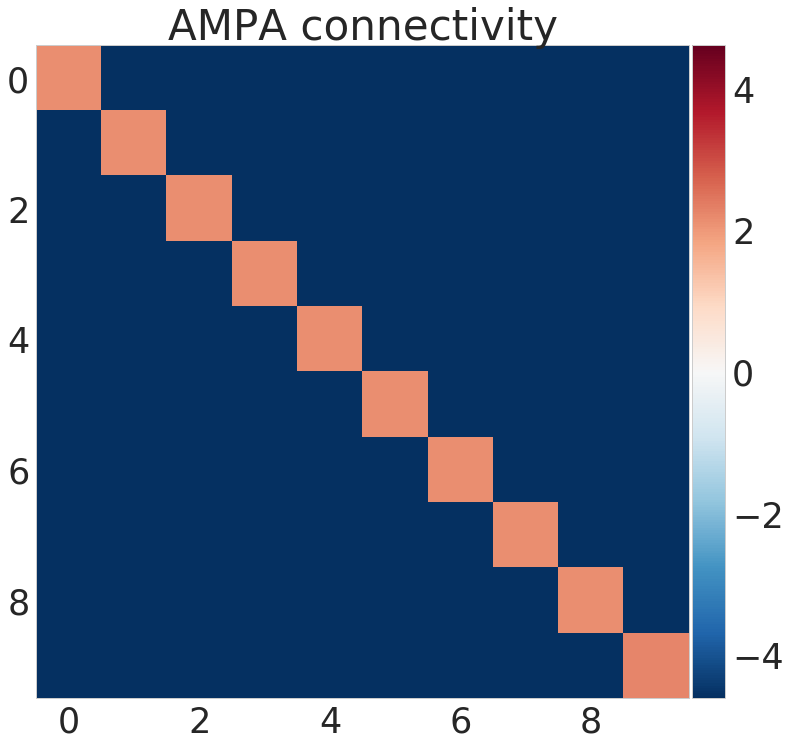

In [222]:
plot_weight_matrix(manager.nn, ampa=True)

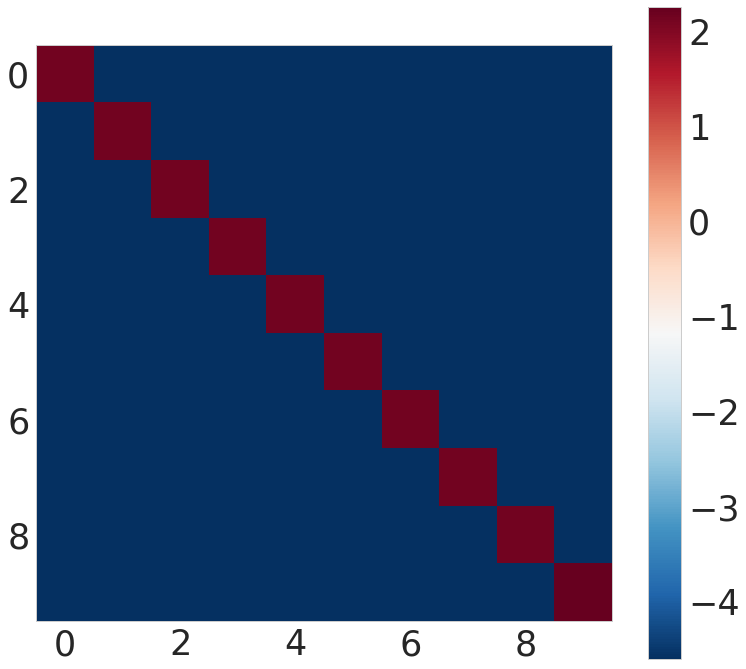

In [224]:
timed_input = TimedInput(minicolumns, hypercolumns, network_representation, dt, training_time, inter_pulse_interval=0.0,
                         inter_sequence_interval=0.0, epochs=2)
S = timed_input.build_timed_input()
z = timed_input.build_filtered_input(0.030)

p, P = calculate_probabilities_from_time_signal(timed_input, filtered=True)
w_timed = get_weights_from_probabilities(p, P, minicolumns, hypercolumns)

cmap = matplotlib.cm.RdBu_r
plt.imshow(w_timed, cmap=cmap)
plt.colorbar();